In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [104]:
# CONSTANTS
tubL, tubW, tubH = 1.20, 0.60, 0.40 # meters
molWaterInM3 = 55493.9 # mol / meter^3
humanCP = 62.97 # J / mol K

In [105]:
# VARIABLES
countL, countW, countH = 12, 6, 4#40, 20, 10#5, 5, 5 #50, 25, 25 # dimensionless
bathStartingTemp = 37.0 # deg celsius
bathThermalDiffusivity = 22e-6 # cast iron thermal diffusivity
dt = 0.1 # seconds

In [113]:
def getWaterDiffusivity(temp):
    lmda = 0.561 + 0.002 * temp + 0.00000962 * (temp ** 2)
    cp = 75.98 - 0.061 * temp + 0.002 * (temp ** 2) - 0.00001755 * (temp ** 3)
    rho = 999.86 + 0.058 * temp - 0.008 * (temp ** 2) + 0.0000397 * (temp ** 3)
    return lmda / (cp * rho)

def getSubsectionVolumeMols():
    return molWaterInM3 * (tubL/countL) * (tubW/countW) * (tubH/countH)

def getNewTempArray():
    return bathStartingTemp*np.ones((countL+1, countW+1, countH+1))

def getTubSafe(tub, l, w, h):
    if l < 0 or l > countL: return bathStartingTemp
    if w < 0 or w > countW: return bathStartingTemp
    if h < 0 or h > countH: return bathStartingTemp
    return tub[l][w][h]

def getPointDiffusivity(tub, l, w, h):
    if l == 0 or l == countL: return bathThermalDiffusivity
    if w == 0 or w == countW: return bathThermalDiffusivity
    if h == 0 or h == countH: return bathThermalDiffusivity
    return getWaterDiffusivity(tub[l][w][h])

def getCellLagrangian(tub, l, w, h):
    distL, distW, distH = tubL/countL, tubW/countW, tubH/countH
    ddL = float(getTubSafe(tub, l+1, w, h) + getTubSafe(tub, l-1, w, h) - 2 * getTubSafe(tub, l, w, h)) / (distL ** 2)
    ddW = float(getTubSafe(tub, l, w+1, h) + getTubSafe(tub, l, w-1, h) - 2 * getTubSafe(tub, l, w, h)) / (distW ** 2)
    ddH = float(getTubSafe(tub, l, w, h+1) + getTubSafe(tub, l, w, h-1) - 2 * getTubSafe(tub, l, w, h)) / (distH ** 2)
    return ddL + ddW + ddH
    
def cellStep(tub):
    diff = np.copy(tub)
    newTub = np.copy(tub)
    for l in range(0, countL+1):
        for w in range(0, countW+1):
            for h in range(0, countH+1):
                wd = getPointDiffusivity(tub, l, w, h)
                dd = getCellLagrangian(tub, l, w, h)
                mm = getSubsectionVolumeMols()
                diff[l][w][h] = dd#dt*mm*wd*dd
                newTub[l][w][h] += dt*mm*wd*dd
    return newTub

[[[ 37.00000001  37.00000002  37.00000003  37.00000002  37.00000001]
  [ 37.00000002  37.00000004  37.00000005  37.00000004  37.00000002]
  [ 37.00000003  37.00000006  37.00000007  37.00000006  37.00000003]
  [ 37.00000003  37.00000006  37.00000008  37.00000006  37.00000003]
  [ 37.00000003  37.00000006  37.00000007  37.00000006  37.00000003]
  [ 37.00000002  37.00000004  37.00000005  37.00000004  37.00000002]
  [ 37.00000001  37.00000002  37.00000003  37.00000002  37.00000001]]

 [[ 37.00000002  37.00000005  37.00000005  37.00000005  37.00000002]
  [ 37.00000005  37.0000001   37.00000011  37.0000001   37.00000005]
  [ 37.00000007  37.00000013  37.00000016  37.00000013  37.00000007]
  [ 37.00000007  37.00000014  37.00000017  37.00000014  37.00000007]
  [ 37.00000007  37.00000013  37.00000016  37.00000013  37.00000007]
  [ 37.00000005  37.0000001   37.00000011  37.0000001   37.00000005]
  [ 37.00000002  37.00000005  37.00000005  37.00000005  37.00000002]]

 [[ 37.00000004  37.00000007  

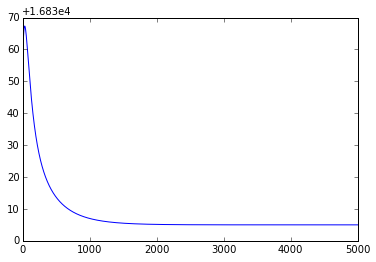

In [120]:
arr = getNewTempArray();
arr[1][1][1] = 90
aList = [np.sum(arr)]

for i in range(0, 5000):
    arr = cellStep(arr)
    aList.append(np.sum(arr))
plt.plot(aList)
print(arr)